# Metody klasterujące dla zbioru urbanGB

Julia Kaznowska, Piotr Wilczyński <br>
12/05/2022 <br>
Politechnika Warszawska, Wydział Matematyki i Nauk Informacyjnych, Wstęp do uczenia maszynowego

## Import niezbędnych bibliotek oraz zbioru danych

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# zbior danych
df = pd.read_csv('urbanGB.txt', sep=",", header=None)
df_lab = pd.read_csv('urbanGB_labels.txt', sep=",", header=None)

# wyświetlanie wizualizacji
%matplotlib inline

## Wstępne informacje o danych

Na podstawie informacji o zbiorze danych wiemy, że w kolumnach podane są koordynaty miejsc w Wielkiej Brytanii, w których wydarzyły się wypadki samochodowe. W dodatkowym pliku (`urbanGB.labels.txt`) przedstawiony jest podział na ponad 450 obszarów miejskich, do których należą poszczególne punkty. Informacja ta będzie przydatna do późniejszego wyznaczenia próbki ze zbioru.

In [39]:
df.columns = ["longitude", "latitude"]

In [40]:
df.head()

,longitude,latitude
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594


In [41]:
df.shape

(360177, 2)

Zbiór danych zawiera 360177 rekordów i 2 kolumny.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360177 entries, 0 to 360176
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   longitude  360177 non-null  float64
 1   latitude   360177 non-null  float64
dtypes: float64(2)
memory usage: 5.5 MB


W zbiorze nie ma braków danych

In [43]:
df.describe()

,longitude,latitude
count,360177.000000,360177.000000
mean,-1.409118,52.562117
std,1.326356,1.374610
min,-5.555990,50.079700
25%,-2.243070,51.496200
50%,-1.441970,52.401200
75%,-0.205373,53.474800
max,1.758340,57.695600


## Metoda K-means

Na początku sprawdzamy optymalną liczbę klastrów metodą łokcia.

In [44]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)

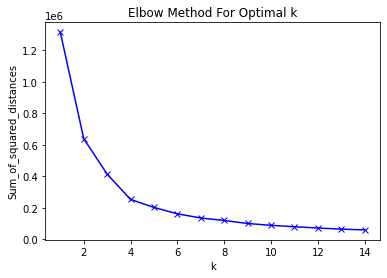

In [45]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Widzimy, że optymalna liczba klastrów wynosi około cztery.

In [46]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)
y_kmeans = kmeans.predict(df)

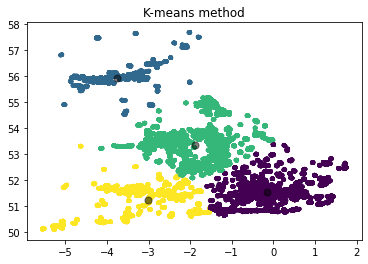

In [47]:
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y_kmeans, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.5)
plt.title("K-means method");

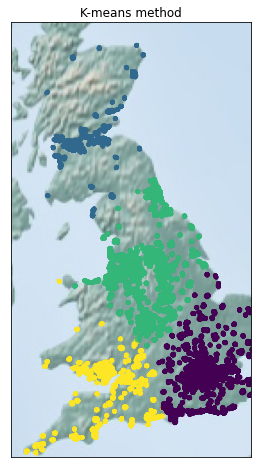

In [48]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8, 8))
lat = df.iloc[:, 1].tolist()
lon = df.iloc[:, 0].tolist()
m = Basemap(projection='lcc', llcrnrlon=-6.,llcrnrlat=50.,urcrnrlon=2.,urcrnrlat=58.,
           lat_0 = 50, lon_0 = -4)
m.shadedrelief()

m.scatter(lon, lat, latlon=True,
          c=y_kmeans, s=10,
          cmap='viridis', alpha=0.5)
plt.title("K-means method");

## Metoda aglomeracyjna

Z uwagi na bardzo duży rozmiar danych przygotowujemy próbkę.

In [49]:
df["label"] = df_lab

In [50]:
y = np.array(df["label"])
X = df.drop(["label"], axis = 1)
X_build, sample, y_build, y_val = train_test_split(
    X, y, stratify=y, test_size=0.05, random_state=321
)

Aby wyznaczyć optymalną liczbę klastrów posłużymy się dendrogramem.

In [51]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [52]:
link = sch.linkage(sample, method='ward')

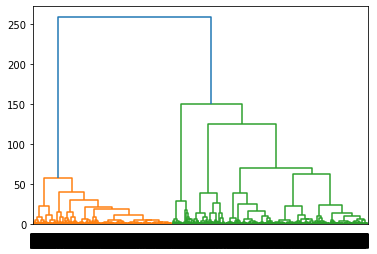

In [53]:
dendrogram = sch.dendrogram(link)

Optymalna liczba klastrów będzie wynosić około 5. Sprawdzimy jednak najpierw jak bardzo różniłby się podział na cztery klastry od tego wyznaczonego przez `k-means`. 

In [54]:
# 4
model4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model4.fit(sample)
labels4 = model4.labels_
y_pred4 = model4.fit_predict(sample)

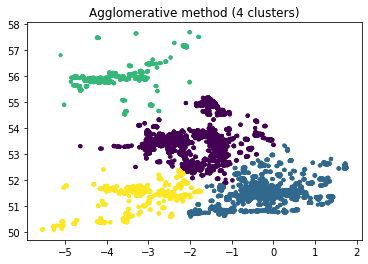

In [55]:
plt.scatter(sample.iloc[:,0], sample.iloc[:,1], c=y_pred4, s=10, cmap='viridis')
plt.title("Agglomerative method (4 clusters)");

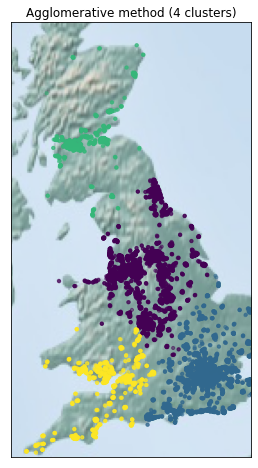

In [56]:
fig = plt.figure(figsize=(8, 8))
lat = sample.iloc[:, 1].tolist()
lon = sample.iloc[:, 0].tolist()
m = Basemap(projection='lcc', llcrnrlon=-6.,llcrnrlat=50.,urcrnrlon=2.,urcrnrlat=58.,
           lat_0 = 50, lon_0 = -4)
m.shadedrelief()

m.scatter(lon, lat, latlon=True,
          c=y_pred4, s=10,
          cmap='viridis', alpha=0.5)
plt.title("Agglomerative method (4 clusters)");

Widzimy, że klastry są do siebie bardzo podobne.

In [57]:
# 5
model5 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model5.fit(sample)
labels5 = model5.labels_
y_pred5 = model5.fit_predict(sample)

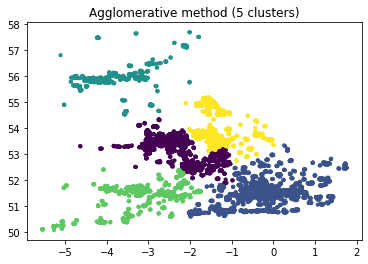

In [58]:
plt.scatter(sample.iloc[:,0], sample.iloc[:,1],c=y_pred5, s=10, cmap='viridis')
plt.title("Agglomerative method (5 clusters)");

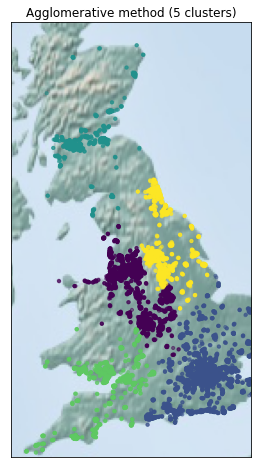

In [59]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8, 8))
lat = sample.iloc[:, 1].tolist()
lon = sample.iloc[:, 0].tolist()
m = Basemap(projection='lcc', llcrnrlon=-6.,llcrnrlat=50.,urcrnrlon=2.,urcrnrlat=58.,
           lat_0 = 50, lon_0 = -4)
m.shadedrelief()

m.scatter(lon, lat, latlon=True,
          c=y_pred5, s=10,
          cmap='viridis', alpha=0.5)
plt.title("Agglomerative method (5 clusters)");

## Podsumowanie

Mimo początkowego podziału na ponad 450 klastrów reprezentujących obszary miejskie okazuje się, że optymalna liczba podziałów w metodach `k-means` i `aglomeracyjnej` oscyluje na poziomie około 5 klastrów. Zdecydowanie zmienia to interpretowalność danych - nie możemy teraz mówić o podziale na obszary miejskie, tylko na regiony. Zwiększanie liczby klastrów nie wprowadziłoby znaczącej poprawy w jakości podziału, zajęłoby jednak dużo więcej czasu 